#Mount Google Drive

The data used in this notebook is shared under the google drive link: https://drive.google.com/drive/folders/15AKvu7snthjZ46-OaXVv7SwK4wYyH7W0?usp=sharing

Add this shared folder, OmdenaMars, to you google drive under path "My Drive/aiml/".

In [0]:
from google.colab import drive
#drive.mount('/content/gdrive')
drive.mount('/content/gdrive', force_remount=False)
GPATH="/content/gdrive/My Drive/aiml/OmdenaMars/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Download Dataset

In [0]:
BASE_PATH="/content/data/"
TRAIN_NATURAL_PATH=BASE_PATH+"train/"+"natural/"
TEST_NATURAL_PATH=BASE_PATH+"test/"+"natural/"
TEST_TECHNO_PATH=BASE_PATH+"test/"+"techno/"
TMP_PATH=BASE_PATH+"tmp/"
WEIGHTS_PATH=GPATH+"weights/anogan/"
RESULTS_PATH=BASE_PATH+"results/"

In [0]:
import pathlib
from shutil import copyfile
import os

pathlib.Path(TRAIN_NATURAL_PATH).mkdir(parents=True, exist_ok=True)
pathlib.Path(TEST_NATURAL_PATH).mkdir(parents=True, exist_ok=True)
pathlib.Path(TEST_TECHNO_PATH).mkdir(parents=True, exist_ok=True)
pathlib.Path(TMP_PATH).mkdir(parents=True, exist_ok=True)
pathlib.Path(WEIGHTS_PATH).mkdir(parents=True, exist_ok=True)
pathlib.Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

if not os.path.isfile(BASE_PATH+"natural.tgz"):
    print("Copying natural.tgz to local folder")
    copyfile(GPATH+"natural.tgz", BASE_PATH+"natural.tgz")
if not os.path.isfile(BASE_PATH+"techno.tgz"):
    print("Copying techno.tgz to local folder")
    copyfile(GPATH+"techno.tgz", BASE_PATH+"techno.tgz")

Copying natural.tgz to local folder
Copying techno.tgz to local folder


In [0]:
# Cleanup old directories
!rm -rf /content/data/train/natural/
!rm -rf /content/data/test/natural/
!rm -rf /content/data/results
!mkdir /content/data/train/natural/
!mkdir /content/data/test/natural/
!mkdir /content/data/results

mkdir: cannot create directory ‘/content/data/results’: File exists


In [0]:
import shutil
import os

print("Extracting techno.tgz")
os.system("tar -xzf "+BASE_PATH+"techno.tgz "+"-C "+TMP_PATH)
print("Extracting techno.tgz, Done.")

for dir in os.listdir(TMP_PATH+"content/gdrive/My Drive/aiml/OmdenaMars/data/techno/"):
    print("Moving Files from:", dir+":")
    for file in os.listdir(TMP_PATH+"content/gdrive/My Drive/aiml/OmdenaMars/data/techno/"+dir):
        #print(file)
        shutil.move(TMP_PATH+"content/gdrive/My Drive/aiml/OmdenaMars/data/techno/"+dir+"/"+file, TEST_TECHNO_PATH+file)

#cleanup temp dir
shutil.rmtree(TMP_PATH+"content")

print("Extracting natural.tgz")
os.system("tar -xzf "+BASE_PATH+"natural.tgz "+"-C "+TMP_PATH)
print("Extracting natural.tgz, Done.")

count = 204800
print("Moving Natural File")
for file in os.listdir(TMP_PATH+"content/gdrive/My Drive/aiml/OmdenaMars/data/natural/"):
    f1 = file.split("_")
    xVal = int(f1[2])
    yVal = int(f1[4].split(".")[0])
    if (xVal >= 8000) and (yVal>=5000):
        if(xVal <= 15000) and (yVal <= 30000):
            shutil.move(TMP_PATH+"content/gdrive/My Drive/aiml/OmdenaMars/data/natural/"+file, TRAIN_NATURAL_PATH+file)
            count -= 1
            if (count <= 0):
                break

print("Move 64 images from train/natural folder to test/natural folder")
count = 64
for file in os.listdir(TRAIN_NATURAL_PATH):
    shutil.move(TRAIN_NATURAL_PATH+file, TEST_NATURAL_PATH+file)
    count -= 1
    if count <= 0:
        break
print("Done")

Extracting techno.tgz
Extracting techno.tgz, Done.
Moving Files from: 2-new-spots-spot2:
Moving Files from: Curiosoity-Rover:
Moving Files from: Heat-Sheild:
Moving Files from: Descent-Stage-Crash-Site:
Moving Files from: 2-new-spots-spot1:
Moving Files from: Parachute:
Extracting natural.tgz
Extracting natural.tgz, Done.
Moving Natural File
Move 64 images from train/natural folder to test/natural folder
Done


# AnoGAN

From: https://github.com/yjucho1/anoGAN

In [0]:
from __future__ import print_function
from keras.models import Sequential, Model
from keras.layers import Input, Reshape, Dense, Dropout, MaxPooling2D, Conv2D, Flatten
from keras.layers import Conv2DTranspose, LeakyReLU
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras import initializers
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import cv2
import math
import csv

from keras.utils. generic_utils import Progbar
 
### combine images for visualization
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:4]
    image = np.zeros((height*shape[0], width*shape[1], shape[2]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1],:] = img[:, :, :]
    return image
 
### generator model define
def generator_model():
    inputs = Input((100,))
    #M#fc1 = Dense(input_dim=10, units=128*7*7)(inputs)
    fc1 = Dense(input_dim=10, units=128*32*32)(inputs)
    fc1 = BatchNormalization()(fc1)
    fc1 = LeakyReLU(0.2)(fc1)
    #M#fc2 = Reshape((7, 7, 128), input_shape=(128*7*7,))(fc1)
    fc2 = Reshape((32, 32, 128), input_shape=(128*64*64,))(fc1)
    up1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(fc2)
    conv1 = Conv2D(64, (3, 3), padding='same')(up1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv1)
    conv2 = Conv2D(1, (5, 5), padding='same')(up2)
    outputs = Activation('tanh')(conv2)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    return model
 
### discriminator model define
def discriminator_model():
    #M#inputs = Input((28, 28, 1))
    inputs = Input((128, 128, 1))
    conv1 = Conv2D(64, (5, 5), padding='same')(inputs)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Dropout(0.2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (5, 5), padding='same')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Dropout(0.2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    fc1 = Flatten()(pool2)
    fc1 = Dense(1)(fc1)
    outputs = Activation('sigmoid')(fc1)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    return model
 
### d_on_g model for training generator
def generator_containing_discriminator(g, d):
    d.trainable = False
    ganInput = Input(shape=(100,))
    x = g(ganInput)
    ganOutput = d(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    #gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
 
def load_generator_model(best=False):
    g = generator_model()
    g_optim = RMSprop(lr=0.0002)
    g.compile(loss='binary_crossentropy', optimizer=g_optim,metrics=['accuracy'])
    if best == True:
        g.load_weights(WEIGHTS_PATH+'generator.best.h5')
    else:
        g.load_weights(WEIGHTS_PATH+'generator.h5')
    return g

def load_discriminator_model(best=False):
    d = discriminator_model()
    d_optim = RMSprop(lr=0.0004)
    d.compile(loss='binary_crossentropy', optimizer=d_optim, metrics=['accuracy'])
    if best == True:
        d.load_weights(WEIGHTS_PATH+'discriminator.best.h5')
    else:
        d.load_weights(WEIGHTS_PATH+'discriminator.h5')
    return d

def load_gan_model(g, d):
    d_on_g = generator_containing_discriminator(g, d)
    d_on_g.compile(loss='binary_crossentropy', optimizer=g_optim,metrics=['accuracy'])
    d_on_g.load_weights(WEIGHTS_PATH+'gan.h5')
    return g


def load_model(best=False):
    g = load_generator_model(best)
    d = discriminator_model(best)
    return g,d

### train generator and discriminator
def train(BATCH_SIZE, X_train_generator, reloadWeights=False):
    
    batch_size = X_train_generator.batch_size        
    n_steps = int(X_train_generator.samples / batch_size)

    ### model define
    if reloadWeights == False:
        d = discriminator_model()
    else:
        d= load_discriminator_model()
        
    if reloadWeights == False:
        g = generator_model()
    else:
        g = load_generator_model()
    
    if reloadWeights == False:
        d_on_g = generator_containing_discriminator(g, d)
    else:
        d_on_g = load_gan_model()
        
    d_optim = RMSprop(lr=0.0004)
    g_optim = RMSprop(lr=0.0002)
    
    if reloadWeights == False:
        #M#g.compile(loss='mse', optimizer=g_optim,metrics=['accuracy'])
        g.compile(loss='binary_crossentropy', optimizer=g_optim,metrics=['accuracy'])
    if reloadWeights == False:
        #M#d_on_g.compile(loss='mse', optimizer=g_optim, metrics=['accuracy'])
        d_on_g.compile(loss='binary_crossentropy', optimizer=g_optim,metrics=['accuracy'])
    d.trainable = True
    if reloadWeights == False:
        #M#d.compile(loss='mse', optimizer=d_optim, metrics=['accuracy'])
        d.compile(loss='binary_crossentropy', optimizer=d_optim, metrics=['accuracy'])
     
    if (not os.path.isfile(WEIGHTS_PATH+"train-status.csv")) or (reloadWeights == False):
        #Initialize train status file
        field_names = ['epoch', 'g-loss', 'g-acc', 'd-loss', 'd-acc']
        with open(WEIGHTS_PATH+"train-status.csv","w") as trainStatusFile:
            tStatusLogger = csv.DictWriter(trainStatusFile, fieldnames=field_names)
            tStatusLogger.writeheader()

    bestDAcc = 0
    bestGLoss = 100
    for epoch in range(300):
        print ("Epoch is", epoch)
        #n_iter = int(X_train.shape[0]/BATCH_SIZE)
        n_iter = int(X_train_generator.samples / BATCH_SIZE)
        progress_bar = Progbar(target=n_iter)
        histGLoss = []
        histGAcc = []
        histDLoss = []
        histDAcc = []
        for index in range(n_iter):
            # create random noise -> U(0,1) 10 latent vectors
            noise = np.random.uniform(0, 1, size=(BATCH_SIZE, 100))
 
            # load real data & generate fake data
            #image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            image_batch = (X_train_generator.next().astype(np.float32) - 127.5) / 127.5
            if (image_batch.shape[0] != BATCH_SIZE):
                #Incomplete last batch, skip to next batch
                image_batch = (X_train_generator.next().astype(np.float32) - 127.5) / 127.5
                
            generated_images = g.predict(noise, verbose=0)
             
            # visualize training results
            if (epoch % 5 == 0) and (index== n_iter-1):
                image = combine_images(generated_images)
                image = image*127.5+127.5
                cv2.imwrite(RESULTS_PATH+str(epoch)+"_"+str(index)+".png", image)
 
            # attach label for training discriminator
            X = np.concatenate((image_batch, generated_images))
            y = np.array([1] * BATCH_SIZE + [0] * BATCH_SIZE)
             
            # training discriminator
            d_loss = d.train_on_batch(X, y)
 
            # training generator
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, np.array([1] * BATCH_SIZE))
            d.trainable = True
 
            progress_bar.update(index+1, values=[('g-loss:',g_loss[0]), ('g-acc',g_loss[1]), ('d-loss:',d_loss[0]),('d-acc:',d_loss[1])])
            histGLoss.append(g_loss[0])
            histGAcc.append(g_loss[1])
            histDLoss.append(d_loss[0])
            histDAcc.append(d_loss[1])
 
        #save train status
        tStatus = {}
        tStatus['epoch'] = epoch
        tStatus['g-loss'] = sum(histGLoss)/len(histGLoss)
        tStatus['g-acc'] = sum(histGAcc)/len(histGAcc)
        tStatus['d-loss'] = sum(histDLoss)/len(histDLoss)
        tStatus['d-acc'] = sum(histDAcc)/len(histDAcc)

        with open(WEIGHTS_PATH+"train-status.csv","a") as trainStatusFile:
            tStatusLogger = csv.DictWriter(trainStatusFile, fieldnames=field_names)
            tStatusLogger.writerow(tStatus)

        # save weights for each epoch
        g.save_weights(WEIGHTS_PATH+'generator.h5', True)
        d.save_weights(WEIGHTS_PATH+'discriminator.h5', True)
        d_on_g.save_weights(WEIGHTS_PATH+'gan.h5', True)
        
        d1 = tStatus['d-acc'] + (1-tStatus['g-loss'])
        if d1 > bestDAcc:
            bestDAcc = d1
            with open(WEIGHTS_PATH+"discriminator.best.txt", "w") as file:
                file.write("Epoch: {} discriminator best acc: {}".format(epoch, d1))
            d.save_weights(WEIGHTS_PATH+'discriminator.best.h5', True)
            
        if ((sum(histGLoss)/len(histGLoss)) < bestGLoss):
            bestGLoss = (sum(histGLoss)/len(histGLoss))
            with open(WEIGHTS_PATH+"generator.best.txt", "w") as file:
                file.write("Epoch: {} generator best loss: {}".format(epoch, bestGLoss))
            g.save_weights(WEIGHTS_PATH+'generator.best.h5', True)
            
    return d, g
 
### generate images
def generate(BATCH_SIZE):
    g = load_generator_model()
    noise = np.random.uniform(0, 1, (BATCH_SIZE, 100))
    generated_images = g.predict(noise)
    return generated_images
 
### anomaly loss function 
def sum_of_residual(y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred))
 
### discriminator intermediate layer feautre extraction
def feature_extractor(d=None):
    if d is None:
        d = load_discriminator_model()
    intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[-7].output)
    intermidiate_model.compile(loss='binary_crossentropy', optimizer='rmsprop')
    return intermidiate_model
 
### anomaly detection model define
def anomaly_detector(g=None, d=None):
    if g is None:
        g = load_generator_model()
    if d is None:
        d = load_discriminator_model()
        
    intermidiate_model = feature_extractor(d)
    intermidiate_model.trainable = False
    g = Model(inputs=g.layers[1].input, outputs=g.layers[-1].output)
    g.trainable = False
    # Input layer cann't be trained. Add new layer as same size & same distribution
    aInput = Input(shape=(100,))
    gInput = Dense((100), trainable=True)(aInput)
    gInput = Activation('sigmoid')(gInput)
     
    # G & D feature
    G_out = g(gInput)
    D_out= intermidiate_model(G_out)    
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights= [0.90, 0.10], optimizer='rmsprop')
     
    # batchnorm learning phase fixed (test) : make non trainable
    K.set_learning_phase(0)
     
    return model
 
### anomaly detection
def compute_anomaly_score(model, x, iterations=500, d=None):
    z = np.random.uniform(0, 1, size=(1, 100))
     
    intermidiate_model = feature_extractor(d)
    d_x = intermidiate_model.predict(x)
 
    # learning for changing latent
    loss = model.fit(z, [x, d_x], batch_size=1, epochs=iterations, verbose=0)
    similar_data, _ = model.predict(z)
     
    loss = loss.history['loss'][-1]
     
    return loss, similar_data

Using TensorFlow backend.


In [0]:
print("generator_model:")
t1 = generator_model()
print(t1.summary())

print("discriminator_model:")
t1 = discriminator_model()
print(t1.summary())

W0617 16:21:58.375554 140504535340928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 16:21:58.564907 140504535340928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 16:21:58.578227 140504535340928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



generator_model:


W0617 16:21:58.672552 140504535340928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0617 16:21:58.753432 140504535340928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0617 16:22:01.788497 140504535340928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0617 16:22:01.906293 140504535340928 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 131072)            13238272  
_________________________________________________________________
batch_normalization_1 (Batch (None, 131072)            524288    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 131072)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 64)        32832     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
__________

## Train Ano-GAN

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_directory=BASE_PATH+"train/"
validation_directory=BASE_PATH+"test/"

train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    directory   = train_directory,       # this is the target directory
    target_size = (128, 128, 1)[:-1],         # all images will be resized to 64x64
    batch_size  = 128,
    color_mode  = "grayscale",                    # We use a grayscale dataset
    classes=["natural"],
    class_mode  = None                            # We do not need to get any label => Everything is healthy
)  


Found 10657 images belonging to 1 classes.


In [0]:
#%debug
Model_d, Model_g = train(128, train_generator)

W0617 16:22:18.472947 140504535340928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0617 16:22:18.485135 140504535340928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch is 0
83/83 [==============================] - 110s 1s/step - g-loss:: 2.0730 - g-acc: 0.3890 - d-loss:: 0.6977 - d-acc:: 0.7136
Epoch is 1
83/83 [==============================] - 97s 1s/step - g-loss:: 0.1819 - g-acc: 0.9596 - d-loss:: 0.5389 - d-acc:: 0.7260
Epoch is 2
83/83 [==============================] - 97s 1s/step - g-loss:: 0.2480 - g-acc: 0.9661 - d-loss:: 0.6235 - d-acc:: 0.6579
Epoch is 3
83/83 [==============================] - 97s 1s/step - g-loss:: 0.0720 - g-acc: 0.9986 - d-loss:: 0.3952 - d-acc:: 0.8261
Epoch is 4
83/83 [==============================] - 97s 1s/step - g-loss:: 0.0160 - g-acc: 1.0000 - d-loss:: 0.3499 - d-acc:: 0.8350
Epoch is 5
83/83 [==============================] - 97s 1s/step - g-loss:: 0.0219 - g-acc: 0.9945 - d-loss:: 0.3062 - d-acc:: 0.8783
Epoch is 6
83/83 [==============================] - 97s 1s/step - g-loss:: 0.0690 - g-acc: 0.9884 - d-loss:: 0.5175 - d-acc:: 0.7335
Epoch is 7
83/83 [==============================] - 98s 1s/step - g-

## Anamoly Detection, Approach - 1

In [0]:
def anomaly_detection(test_img, g=None, d=None):
    model = anomaly_detector(g=g, d=d)
    ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, 256, 256, 1), iterations=500, d=d)

    # anomaly area, 255 normalization
    np_residual = test_img.reshape(256,256,1) - similar_img.reshape(256,256,1)
    np_residual = (np_residual + 2)/4

    np_residual = (255*np_residual).astype(np.uint8)
    original_x = (test_img.reshape(256,256,1)*127.5+127.5).astype(np.uint8)
    similar_x = (similar_img.reshape(256,256,1)*127.5+127.5).astype(np.uint8)

    original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x_color, 0.3, residual_color, 0.7, 0.)

    return ano_score, original_x, similar_x, show


In [0]:
#test_image_batch = (natural_validation_generator.next()[0:5].astype(np.float32) - 127.5) / 127.5
#for image in test_image_batch:
#    img_idx = 0
#    start = cv2.getTickCount()
#    score, qurey, pred, diff = anomaly_detection(image, Model_g, Model_d)
#    time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000
#    print ('techno image: %d : done'%( img_idx), 'Score: %.2f'%score, 'Time:%.2fms'%time)


techno image: 0 : done Score: 12296.56 Time:9583.61ms
techno image: 0 : done Score: 21023.97 Time:9535.10ms
techno image: 0 : done Score: 18588.28 Time:9842.25ms
techno image: 0 : done Score: 15228.32 Time:10356.36ms
techno image: 0 : done Score: 19894.46 Time:10160.00ms


In [0]:
#test_image_batch = (techno_validation_generator.next()[0:5].astype(np.float32) - 127.5) / 127.5
#for image in test_image_batch:
#    img_idx = 0
#    start = cv2.getTickCount()
#    score, qurey, pred, diff = anomaly_detection(image, Model_g, Model_d)
#    time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000
#    print ('techno image: %d : done'%( img_idx), 'Score: %.2f'%score, 'Time:%.2fms'%time)


techno image: 0 : done Score: 23380.92 Time:8456.15ms
techno image: 0 : done Score: 12817.43 Time:8430.62ms
techno image: 0 : done Score: 53128.41 Time:8832.68ms
techno image: 0 : done Score: 8442.28 Time:9100.25ms
techno image: 0 : done Score: 22049.61 Time:9794.49ms


In [0]:
#test_image_batch.shape

(5, 256, 256, 1)

In [0]:
#import matplotlib.pyplot as plt
#%matplotlib inline
#
#plt.figure(1, figsize=(3, 3))
#plt.title('query image')
#plt.imshow(qurey.reshape(64,64), cmap=plt.cm.gray)
#
#print("anomaly score : ", score)
#plt.figure(2, figsize=(3, 3))
#plt.title('generated similar image')
#plt.imshow(pred.reshape(64,64), cmap=plt.cm.gray)
#
#plt.figure(3, figsize=(3, 3))
#plt.title('anomaly detection')
#plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
#plt.show()


## Anamoly Detection, Approach - 2

In [0]:
from sklearn.metrics import confusion_matrix

def detect_defects(discriminator_model, validation_generator, threshold=0.5, verbose=1):

        total_samples = validation_generator.samples
        batch_size = validation_generator.batch_size

        results = list()
        labels = list()

        if (verbose != 0):
            progress_bar = Progbar(target=total_samples)

        for _ in range(np.ceil(total_samples / batch_size).astype(np.int32)):

            image_batch, lbls = validation_generator.next()

            labels = np.append(labels, lbls.reshape(lbls.shape[0]))
            image_batch = (image_batch.astype(np.float32) - 127.5) / 127.5

            tmp_rslt = discriminator_model.predict(
                x=image_batch,
                batch_size=image_batch.shape[0],
                verbose=0
            )

            if (verbose != 0):
                progress_bar.add(image_batch.shape[0])

            results = np.append(results, tmp_rslt.reshape(tmp_rslt.shape[0]))

        results = [1 if x >= threshold else 0 for x in results]

        tn, fp, fn, tp = confusion_matrix(labels, results).ravel()
        print("tn:", tn, "fp:", fp, "fn:", fn, "tp:", tp)

        #################### NON DEFECT SITUATIONS ####################

        # Probability of Detecting a Non-Defect: (tp / (tp + fn))
        if ((tp + fn) != 0):
            recall = tp / (tp + fn)
        else:
            recall = 0.0

        # Probability of Correctly Detecting a Non-Defect: (tp / (tp + fp))

        if ((tp + fp) != 0):
            precision = tp / (tp + fp)
        else:
            precision = 0.0

        ###################### DEFECT SITUATIONS ######################

        # Probability of Detecting a Defect: (tn / (tn + fp))
        if ((tn + fp) != 0):
            specificity = tn / (tn + fp)
        else:
            specificity = 0.0

        # Probability of Correctly Detecting a Defect: (tn / (tn + fn))
        if ((tn + fn) != 0):
            negative_predictive_value = tn / (tn + fn)
        else:
            negative_predictive_value = 0.0

        return precision, recall, specificity, negative_predictive_value


In [0]:
# this is a similar generator, for validation data
test_datagen = ImageDataGenerator()

validation_generator = test_datagen.flow_from_directory(
    directory   = validation_directory,     # this is the target directory
    target_size = (128, 128, 1)[:-1],         # all images will be resized to 64x64
    batch_size  = 64,
    color_mode  = "grayscale",              # We use a grayscale dataset
    classes     = ["natural", "techno"],        # {'docs': 0, 'other': 1} => Needs to be enforced
    class_mode  = 'binary'                  # We want to have binary labels for validation
)


#predict
d = load_discriminator_model(best=False)
precision, recall, specificity, negative_predictive_value = detect_defects(d, validation_generator,threshold=0.3)

print("Probability of Detecting a Non-Defect             => Recall      (tp / (tp + fn)):", recall)
print("Probability of Correctly Detecting a Non-Defect   => Precision   (tp / (tp + fp)):", precision)
print("Probability of Detecting a Defect                 => Specificity (tn / (tn + fp)):", specificity)
print("Probability of Correctly Detecting a Defect       => NPV         (tn / (tn + fn)):", negative_predictive_value)

Found 114 images belonging to 2 classes.
114/114 [==============================] - 0s 3ms/step
tn: 56 fp: 8 fn: 40 tp: 10
Probability of Detecting a Non-Defect             => Recall      (tp / (tp + fn)): 0.2
Probability of Correctly Detecting a Non-Defect   => Precision   (tp / (tp + fp)): 0.5555555555555556
Probability of Detecting a Defect                 => Specificity (tn / (tn + fp)): 0.875
Probability of Correctly Detecting a Defect       => NPV         (tn / (tn + fn)): 0.5833333333333334


In [0]:
validation_generator.class_indices

{'natural': 1, 'techno': 0}

In [0]:
from numpy import newaxis
folder=validation_directory+"techno"

technoPredictions = []
for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename),0)
    img = cv2.resize(img,(128,128))
    img = (img.astype(np.float32) - 127.5) / 127.5
    im2 = np.array([img])
    im2 = im2[:,:,:,newaxis]
    #print(im2.shape)
    tmp_rslt = d.predict(x=im2,
                batch_size=1,
                verbose=0
            )
    technoPredictions.append(tmp_rslt[0][0])
    print(filename, tmp_rslt[0][0])
    
    

img_x_7552_y_22400.jpg 1.0
img_x_6912_y_20608.jpg 0.9883857
img_x_7296_y_22144.jpg 0.31642044
img_x_15488_y_22528.jpg 0.9999914
img_x_15616_y_22656.jpg 0.99998665
img_x_7552_y_22144.jpg 1.0
img_x_6528_y_19584.jpg 0.15875597
img_x_6400_y_19584.jpg 0.20403388
img_x_6656_y_19584.jpg 0.21504915
img_x_7424_y_22272.jpg 1.0
img_x_6656_y_19456.jpg 0.06714094
img_x_7040_y_20480.jpg 0.9870509
img_x_9728_y_21376.jpg 0.9757642
img_x_6784_y_20736.jpg 0.1392769
img_x_6528_y_19712.jpg 0.24852754
img_x_6784_y_20480.jpg 0.13802381
img_x_7552_y_22272.jpg 1.0
img_x_9728_y_21504.jpg 0.92922115
img_x_7040_y_20608.jpg 0.9585537
img_x_7168_y_20480.jpg 0.6556935
img_x_7296_y_22400.jpg 0.071307056
img_x_15616_y_22528.jpg 0.9999937
img_x_7296_y_20608.jpg 0.79291654
img_x_15360_y_22656.jpg 0.063316256
img_x_6784_y_20608.jpg 0.18692394
img_x_7424_y_22144.jpg 1.0
img_x_7680_y_22272.jpg 0.5158083
img_x_9600_y_21504.jpg 0.8906618
img_x_6656_y_19712.jpg 0.17712303
img_x_15488_y_22656.jpg 0.99998844
img_x_7168_y_20352

In [0]:
from numpy import newaxis
folder=validation_directory+"natural"

naturalPredictions = []
for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename),0)
    img = cv2.resize(img,(128,128))
    img = (img.astype(np.float32) - 127.5) / 127.5
    im2 = np.array([img])
    im2 = im2[:,:,:,newaxis]
    #print(im2.shape)
    tmp_rslt = d.predict(x=im2,
                batch_size=1,
                verbose=0
            )
    naturalPredictions.append(tmp_rslt[0][0])
    print(filename, tmp_rslt[0][0])

img_x_10752_y_17408.jpg 0.14697611
img_x_11648_y_16896.jpg 0.19080912
img_x_13568_y_7808.jpg 0.14173661
img_x_14336_y_18688.jpg 0.22423638
img_x_9472_y_29184.jpg 0.9882239
img_x_10368_y_8960.jpg 0.20709567
img_x_11648_y_21504.jpg 0.019217575
img_x_14720_y_8448.jpg 0.3724327
img_x_11520_y_9984.jpg 0.36900547
img_x_14720_y_8192.jpg 0.074692704
img_x_12288_y_13440.jpg 0.4571508
img_x_10752_y_7552.jpg 0.26875517
img_x_13824_y_17408.jpg 0.06876851
img_x_9728_y_10880.jpg 0.1346322
img_x_9856_y_18176.jpg 0.014412622
img_x_9856_y_22016.jpg 0.13594581
img_x_11648_y_9984.jpg 0.6636361
img_x_10240_y_25344.jpg 0.27711833
img_x_12672_y_18176.jpg 0.098404996
img_x_14976_y_13184.jpg 0.059294216
img_x_11264_y_29440.jpg 0.9999976
img_x_9216_y_28544.jpg 0.3732963
img_x_9472_y_9728.jpg 0.5726497
img_x_9472_y_6784.jpg 0.14794983
img_x_9600_y_9088.jpg 0.21641523
img_x_12288_y_29824.jpg 0.9999727
img_x_12032_y_18688.jpg 0.091706984
img_x_8960_y_6144.jpg 0.08773631
img_x_11776_y_13056.jpg 0.045334373
img_x_9

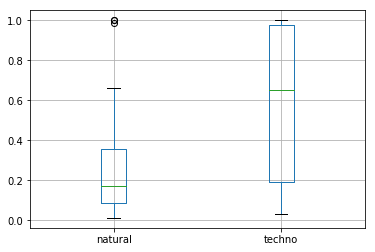

In [0]:
import pandas as pd
df = pd.DataFrame({'natural':naturalPredictions[:50],'techno':technoPredictions})
df.boxplot(column=['natural','techno'])

('img_x_10752_y_17408.jpg', 0.012893274)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe713449e8>,
      dtype=object)

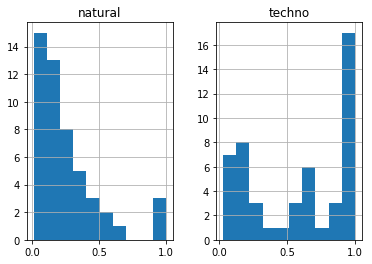

In [0]:
df.hist()